In [1]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.extensions import HamiltonianGate
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
from qiskit.quantum_info import Statevector, Operator
from qiskit.opflow import CircuitStateFn
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
import scipy 
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
## import optimisers
from qiskit.algorithms.optimizers import COBYLA
from scipy.optimize import minimize

In [3]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

In [19]:
## sub-routines for QFT  ~
def crot(qc, l):
    """ Function to generate Controlled Rotation Ooeration  """
    if l == 0:
        return qc
    l = l-1
    qc.h(l)
    for q in range(l):
        qc.cp(pi/2**(l-q), q, l)
    #qc.barrier()
    # qc.draw()
    
def QFT(qc):
   """function to generate QFT circuit """
   dim = qc.num_qubits
   for q in range(dim):
      crot(qc, dim-q)
   for q in range(int(dim/2)):
      qc.swap(q, dim-q-1)

   #qc.draw()
   return qc
   

### Quantum Dictionary
Implement a quantum algorithm to store (key, value) pairs in the same form a regular hash-based dictionary works. 

Given the keys $\{k_i\}$ and values $\{v_i\}$ the quantum dictionary implements a circuit to prepare the state
$$  \ket{\psi(k,v)} = \sum_{k_i} \ket{k_i}\ket{v_i}  $$


Our purpose here is to use the quantum dictionary format to store the function evaluations of the an function 'f(k)' on the keys 'k',
$$  \ket{\psi(f)} = \sum_{k_i} \ket{k_i}\ket{f(k_i)} $$

Example: 
There's a function 
'f(x)'such that
$$ f(0) = 5, f(3) = 7
$$

In [79]:
precision = 3
qreg = QuantumRegister(2, name= 'qreg')
qm = QuantumRegister(precision, name= 'precision')
ancilla = QuantumRegister(1, name= 'ancilla')
creg_q = ClassicalRegister(2, name='creg')
creg_qm = ClassicalRegister(precision, name= 'precision_c')

qc = QuantumCircuit(qreg, qm, ancilla, creg_qm, creg_q)

qc.h(qreg)
qc.h(qm)
qc.rx(pi/2, ancilla)
qc.z(ancilla)
qc.x(ancilla)
qc.barrier()

# qc.x(qreg[0])
# qc.mcry(  4*(2*pi/2**4)*2, [qreg[0],qm[0]],ancilla)
# qc.mcry(  4*(2*pi/2**4)*2, [qreg[0],qreg[1],qm[0]],ancilla)
# qc.mcry(  1*(2*pi/2**4)*2, [qreg[1],qm[0]],ancilla)
qc.x(qreg)
qc.mcry(5*(2*pi/2**precision)*2, [qreg[0], qreg[1], qm[0]], ancilla)
qc.mcry(5*(2*pi/2**precision)*4, [qreg[0], qreg[1], qm[1]], ancilla)
qc.mcry(5*(2*pi/2**precision)*8, [qreg[0], qreg[1], qm[2]], ancilla)
qc.x(qreg)

# qc.x(qreg)
qc.mcry(7*(2*pi/2**precision)*2, [qreg[0], qreg[1], qm[0]], ancilla)
qc.mcry(7*(2*pi/2**precision)*4, [qreg[0], qreg[1], qm[1]], ancilla)
qc.mcry(7*(2*pi/2**precision)*8, [qreg[0], qreg[1], qm[2]], ancilla)
# qc.x(qreg)


qc.append(QFT(QuantumCircuit(precision, name= 'QFT')).to_gate().inverse() , [2,3,4]  )
qc.barrier()
# qc.draw()




In [80]:
qc.measure(qreg, creg_q )
qc.measure(qm, creg_qm)
# qc.draw()


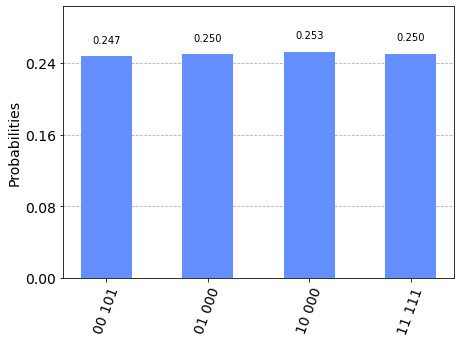

In [81]:
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)

{'11 000': 2482, '00 101': 2471, '01 000': 2542, '10 000': 2529}

## QUBO us